Use pydicom when reading the downloaded DICOM images. Install pydicom. Use pylidc to read the metadata for the LIDC-IRDI dataset.
pylidc has the metadata for the dataset whicn can be queried just my installing the library and not needing to load any images. 

In [1]:
#!git clone https://github.com/pieper/dicomsort.git
!pip install pydicom
!pip install pylidc
#!python dicomsort/dicomsort.py --help

     |████████████████████████████████| 2.0 MB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 7.6 MB/s eta 0:00:01     |█▉                              | 317 kB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 61.4 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 70.4 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 61.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 53.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 58.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 78.6 MB/s eta 0:00:01
     |████████████████████████████████| 171 kB 70.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 20.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 64.6 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 70.1 MB/s eta 0:00:01


In [3]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt

Let's query some metadata from the LIDC dataset using pylidc

In [4]:
pl.query(pl.Scan).count()
pid = 'LIDC-IDRI-0069'#'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
scan.study_instance_uid

'1.3.6.1.4.1.14519.5.2.1.6279.6001.303241414168367763244410429787'

#### If all DICOM images are already downloaded, we just need to load the list from the sorted directory

In [5]:
import os
data_folder = os.getcwd() + '/cohort_sorted_3/'
data_folder

'/app/cohort_sorted_3/'

In [6]:
#f = open ('.pylidcrc','w')            #For GCP
f = open ('/root/.pylidcrc','w')    #For Colab
f.write('[dicom]'+'\n')
f.write('path =' + data_folder +'\n')
f.write('warn = True')
f.close()

In [7]:
# get all patients
cohort = data_folder
patient_list = os.listdir(cohort)
print("There are {} patients".format(len(patient_list)))

There are 145 patients


We will need to extract the images from DICOM and save them as images into the disk for loading during training. pylidc is not multithreaded, we cannot load the images directly from the DICOM using generators in tf.data.Dataset. Let's split the patient list into train and test.

In [16]:
#def split patient list
def split_patients(patient_list, split=0.7):
    idxs = np.arange(len(patient_list))
    np.random.shuffle(idxs)
    num = len(patient_list)
    return np.array(patient_list)[idxs[:int(0.7*num)]], np.array(patient_list)[idxs[int(0.7*num):]]

In [17]:
train_patients, test_patients = split_patients(patient_list, 0.7)
print("Number of patients in train is {} and test is {}".format(len(train_patients), len(test_patients)))

Number of patients in train is 101 and test is 44


#### Extract and save images to a folder

We will use the PIL / Pillow to save the images extracted from DICOM to folders for train and test.
We will create the directories for the images, both train and test.

In [ ]:
# !mkdir -p data/train/images/
# !mkdir -p data/train/masks/
# !mkdir -p data/test/images/
# !mkdir -p data/test/masks/

In [19]:
# get image
from PIL import Image

# save image and mask
def save_patient_images_and_masks(patient_id, root_dir='/data/train'):
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    vol = scan.to_volume()

    # get mask for patient
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)   

    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)

    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]    
        CT_mask[cbbox] += cmask

    for slice_id in range(vol.shape[2]):
        image = vol[:,:,slice_id]
        mask = CT_mask[:,:,slice_id]
#         im = Image.fromarray(image)
#         msk = Image.fromarray(mask)
        image_file_name = root_dir + "/images/" + "img" + "_" + str(patient_id) + "_" + str(slice_id) + ".npz"
        mask_file_name = root_dir + "/masks/" + "mask" + "_" + str(patient_id) + "_" + str(slice_id) + ".npz"
#         im.convert('RGB').save(image_file_name)
#         msk.convert('RGB').save(mask_file_name)
        np.savez_compressed(image_file_name, image)
        np.savez_compressed(mask_file_name, mask)

In [18]:
#!rm -rf /data/train
#!rm -rf /data/test

In [20]:
image_path = '/data/images'
mask_path = '/data/masks'
root_dir  = '/data/train'
os.mkdir(root_dir)
os.mkdir(root_dir + '/images')
os.mkdir(root_dir + '/masks')
for pat in train_patients:
    save_patient_images_and_masks(pat, root_dir)

Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a 

In [24]:
image_path = '/data/images'
mask_path = '/data/masks'
root_dir  = '/data/test'
os.mkdir(root_dir)
os.mkdir(root_dir + '/images')
os.mkdir(root_dir + '/masks')
for pat in test_patients:
    save_patient_images_and_masks(pat, root_dir)

Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and 

In [47]:
ls data/train/images

img_LIDC-IDRI-0078_0.npy    img_LIDC-IDRI-0405_130.npy
img_LIDC-IDRI-0078_1.npy    img_LIDC-IDRI-0405_131.npy
img_LIDC-IDRI-0078_10.npy   img_LIDC-IDRI-0405_132.npy
img_LIDC-IDRI-0078_11.npy   img_LIDC-IDRI-0405_133.npy
img_LIDC-IDRI-0078_12.npy   img_LIDC-IDRI-0405_134.npy
img_LIDC-IDRI-0078_13.npy   img_LIDC-IDRI-0405_135.npy
img_LIDC-IDRI-0078_14.npy   img_LIDC-IDRI-0405_136.npy
img_LIDC-IDRI-0078_15.npy   img_LIDC-IDRI-0405_137.npy
img_LIDC-IDRI-0078_16.npy   img_LIDC-IDRI-0405_138.npy
img_LIDC-IDRI-0078_17.npy   img_LIDC-IDRI-0405_139.npy
img_LIDC-IDRI-0078_18.npy   img_LIDC-IDRI-0405_14.npy
img_LIDC-IDRI-0078_19.npy   img_LIDC-IDRI-0405_140.npy
img_LIDC-IDRI-0078_2.npy    img_LIDC-IDRI-0405_141.npy
img_LIDC-IDRI-0078_20.npy   img_LIDC-IDRI-0405_142.npy
img_LIDC-IDRI-0078_21.npy   img_LIDC-IDRI-0405_143.npy
img_LIDC-IDRI-0078_22.npy   img_LIDC-IDRI-0405_144.npy
img_LIDC-IDRI-0078_23.npy   img_LIDC-IDRI-0405_145.npy
img_LIDC-IDRI-0078_24.npy   img_LIDC-IDRI-0405_146.npy
img_LIDC-ID

In [28]:
ls /data/train/images/img_LIDC-IDRI-0078_1.npz

/data/train/images/img_LIDC-IDRI-0078_1.npz


Verify one of the images we saved

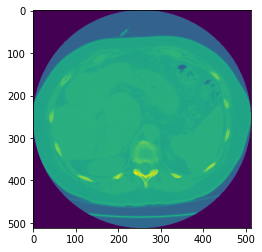

In [44]:
arr = np.load('/data/train/images/img_LIDC-IDRI-0078_1.npz')
plt.imshow(arr['arr_0'])

In [43]:
arr['arr_0']

array([[-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       ...,
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048]], dtype=int16)

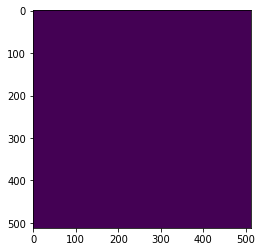

In [47]:
arr = np.load('/data/train/masks/mask_LIDC-IDRI-0078_1.npz')
plt.imshow(arr['arr_0'])

In [7]:
# nodules_annotation = scan.cluster_annotations()
# cmask_CT = []
# cbbox_CT = []
# masks_CT = []
# vol = scan.to_volume()

# cmask_CT = []
# cbbox_CT = []
# masks_CT = []
# for nodule_idx, nodule in enumerate(nodules_annotation):
#     cmask, cbbox, masks = consensus(nodule)
#     cmask_CT.append(cmask)
#     cbbox_CT.append(cbbox)
#     masks_CT.append(masks)   

# nodule_num = len(cmask_CT)
# plt.figure(figsize=(8*3,8*nodule_num))
# for i in range(nodule_num):
#     cmask = cmask_CT[i]
#     cbbox = cbbox_CT[i]
#     masks = masks_CT[i]
#     k = int(0.5*(cbbox[2].stop - cbbox[2].start))
#     k_slice = k + cbbox[2].start
#     plt.subplot(nodule_num,3,1+i*3)
#     plt.imshow(vol[:,:,k_slice],cmap='gray')
#     plt.clim(vmin=-1350,vmax=-150)
    
#     plt.subplot(nodule_num,3,2+i*3)
#     CT_mask = np.zeros_like(vol)
#     CT_mask[cbbox] = cmask
#     plt.imshow(CT_mask[:,:,k_slice])

#     plt.subplot(nodule_num,3,3+i*3)
#     plt.imshow(vol[cbbox][:,:,k],cmap='gray')
#     # Plot the annotation contours for the kth slice.
#     colors = ['r', 'g', 'b', 'y']
#     for j in range(len(masks)):
#         for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
#             label = "Annotation %d" % (j+1)
#             plt.plot(c[:,1], c[:,0], colors[j], label=label)

#     # Plot the 50% consensus contour for the kth slice.
#     for c in find_contours(cmask[:,:,k].astype(float), 0.5):
#         plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

In [8]:
# patient_list = os.listdir(cohort)
# patient_list

In [5]:
from numpy import random

In [6]:
# os.mkdir('data/train')
# os.mkdir('data/train/image')
# os.mkdir('data/train/mask')
# os.mkdir('data/val')
# os.mkdir('data/val/image')
# os.mkdir('data/val/mask')

# train_image_root = 'data/train/image/'
# train_mask_root  = 'data/train/mask/'
# val_image_root   = 'data/val/image/'
# val_mask_root    = 'data/val/mask/'

# val_ratio = 0.2
# SEED = 1
# random.seed(SEED)
# file_list = [i for i in range(len(patient_list))]
# random.shuffle(file_list)
# train_list = file_list[:int(len(patient_list)*(1-val_ratio))]
# val_list = file_list[int(len(patient_list)*(1-val_ratio)):]

# for i in train_list:
#     for j in range(CT_image_data[i].shape[2]):
#         image_npfile = train_image_root+str(i)+'-'+str(j)+'.npy'
#         mask_npfile  = train_mask_root+str(i)+'-'+str(j)+'.npy'
#         np.save(image_npfile, CT_image_data[i][:,:,j][np.newaxis,:])
#         np.save(mask_npfile, CT_mask_data[i][:,:,j][np.newaxis,:])
        
# for i in val_list:
#     for j in range(CT_image_data[i].shape[2]):
#         image_npfile = val_image_root+str(i)+'-'+str(j)+'.npy'
#         mask_npfile  = val_mask_root+str(i)+'-'+str(j)+'.npy'
#         np.save(image_npfile, CT_image_data[i][:,:,j][np.newaxis,:])
#         np.save(mask_npfile, CT_mask_data[i][:,:,j][np.newaxis,:])   
        
# train_files = os.listdir(train_image_root)
# val_files   = os.listdir(val_image_root)
# train_image_paths = [train_image_root + path for path in train_files]
# train_mask_paths  = [train_mask_root + path for path in train_files]
# val_image_paths   = [val_image_root + path for path in val_files]
# val_mask_paths    = [val_mask_root + path for path in val_files]
# print(len(train_image_paths),len(train_mask_paths))
# print(len(val_image_paths),len(val_mask_paths))

### Download the data from IDC

In [34]:
myProjectID = "idc-external-012"

In [35]:
# this setting is only to be used in cloab notebooks
# from google.colab import auth
# auth.authenticate_user()

Install necessary packages to query the data from bigquery tables and datastores

In [36]:
!pip install google-cloud-bigquery
!pip install --upgrade google-auth-oauthlib
!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'

     |████████████████████████████████| 201 kB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.9 MB 71.4 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 3.1 MB/s  eta 0:00:01
     |████████████████████████████████| 75 kB 7.5 MB/s  eta 0:00:01
     |████████████████████████████████| 92 kB 854 kB/s  eta 0:00:01
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0+nv requires grpcio~=1.34.0, but you have grpcio 1.41.0 which is incompatible.
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.5
    Uninstalling google-auth-oauthlib-0.4.5:
      Successfully uninstalled google-auth-oauthlib-0.4.5
     |████████████████████

Set up access to the bigquery assets using your authentication tokens

In [235]:
from google_auth_oauthlib import flow

# TODO: Uncomment the line below to set the `launch_browser` variable.
launch_browser = False
#
# The `launch_browser` boolean variable indicates if a local server is used
# as the callback URL in the auth flow. A value of `True` is recommended,
# but a local server does not work if accessing the application remotely,
# such as over SSH or from a remote Jupyter notebook.

appflow = flow.InstalledAppFlow.from_client_secrets_file(
    "client_secret_desktop.json", scopes=["https://www.googleapis.com/auth/bigquery"]
)

if launch_browser:
    appflow.run_local_server()
else:
    appflow.run_console()

credentials = appflow.credentials

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=354066013909-il5lh54dbass54iv45m7thff0uuefjar.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=YBVzEphzTNFS70dMdospF6FzLZMW91&prompt=consent&access_type=offline


Enter the authorization code:  4/1AX4XfWgMOsrjSrQePTSXoxUmc9UEu0i8fbQxt5BT5-JE3Hq9jZOYuLDJnzs


In [238]:
%load_ext google.cloud.bigquery

In [240]:
from google.cloud.bigquery import magics
magics.context.credentials = credentials

A sample big query to see if everything is working

In [14]:
%%bigquery
SELECT
    source_year AS year,
    COUNT(is_male) AS birth_count
FROM `bigquery-public-data.samples.natality`
GROUP BY year
ORDER BY year DESC
LIMIT 15

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 11.83rows/s]


year  birth_count
0   2008      4255156
1   2007      4324008
2   2006      4273225
3   2005      4145619
4   2004      4118907
5   2003      4096092
6   2002      4027376
7   2001      4031531
8   2000      4063823
9   1999      3963465
10  1998      3945192
11  1997      3884329
12  1996      3894874
13  1995      3903012
14  1994      3956925

Explore all columns in our LIDC dataset

In [267]:
%%bigquery CT_columns --project=$myProjectID 
select * FROM `canceridc-data.idc_views.dicom_all` where Modality = "CT" limit 1
# WITH
#   all_lidc_ct_series AS (
#   SELECT
#     DISTINCT(SeriesInstanceUID),
#     StudyInstanceUID,  
#     PatientID,
#     SliceThickness,
#     ARRAY_TO_STRING(PixelSpacing,"/") as pixelspa 
#   FROM
#     `canceridc-data.idc_views.dicom_all`
#   WHERE
#     Modality = "CT"
#     AND collection_id = "lidc_idri")
# SELECT PatientID,SliceThickness,pixelspa,StudyInstanceUID,SeriesInstanceUID FROM
#   all_lidc_ct_series
# ORDER BY
#   PatientID

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/rows]


In [268]:
CT_columns.columns.to_list()

['Source_DOI',
 'tcia_tumorLocation',
 'tcia_species',
 'tcia_cancerType',
 'collection_id',
 'gcs_url',
 'gcs_bucket',
 'gcs_generation',
 'crdc_study_uuid',
 'crdc_series_uuid',
 'crdc_instance_uuid',
 'MediaStorageSOPClassUID',
 'MediaStorageSOPInstanceUID',
 'TransferSyntaxUID',
 'ImplementationClassUID',
 'ImplementationVersionName',
 'SourceApplicationEntityTitle',
 'ReferencedFileID',
 'LengthToEnd',
 'SpecificCharacterSet',
 'ImageType',
 'RecognitionCode',
 'InstanceCreationDate',
 'InstanceCreationTime',
 'InstanceCreatorUID',
 'SOPClassUID',
 'SOPInstanceUID',
 'StudyDate',
 'SeriesDate',
 'AcquisitionDate',
 'ContentDate',
 'OverlayDate',
 'CurveDate',
 'AcquisitionDateTime',
 'StudyTime',
 'SeriesTime',
 'AcquisitionTime',
 'ContentTime',
 'DataSetType',
 'DataSetSubtype',
 'AccessionNumber',
 'RetrieveAETitle',
 'Modality',
 'ModalitiesInStudy',
 'ConversionType',
 'PresentationIntentType',
 'Manufacturer',
 'CodingSchemeDesignator',
 'CodingSchemeIdentificationSequence',

Run the actual query to bring in the DICOM images metadata from LIDC dataset

In [285]:
%%bigquery CT_details --project=$myProjectID 
#tcia_tumorLocation
WITH
  all_lidc_ct_series AS (
  SELECT
    DISTINCT(SeriesInstanceUID),
    StudyInstanceUID,  
    PatientID,
    SliceThickness,
      SpacingBetweenSlices,
      SliceLocation,
      NumberOfSlices,
      SliceSensitivityFactor,
      tcia_tumorLocation,
      BodyPartThickness,
    ARRAY_TO_STRING(PixelSpacing,"/") as pixelspa 
  FROM
    `canceridc-data.idc_views.dicom_all`
  WHERE
    Modality = "CT"
    AND collection_id = "lidc_idri")
SELECT PatientID,SliceThickness,SpacingBetweenSlices,
      SliceLocation,
      NumberOfSlices,
      SliceSensitivityFactor,pixelspa,StudyInstanceUID,SeriesInstanceUID,tcia_tumorLocation,BodyPartThickness FROM
  all_lidc_ct_series
ORDER BY
  PatientID

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████| 243945/243945 [00:01<00:00, 212800.77rows/s]


In [286]:
CT_details.head()

PatientID SliceThickness SpacingBetweenSlices SliceLocation  \
0  LIDC-IDRI-0001       2.500000                 None   -172.500000   
1  LIDC-IDRI-0001       2.500000                 None   -297.500000   
2  LIDC-IDRI-0001       2.500000                 None    -20.000000   
3  LIDC-IDRI-0001       2.500000                 None   -235.000000   
4  LIDC-IDRI-0001       2.500000                 None   -162.500000   

   NumberOfSlices SliceSensitivityFactor           pixelspa  \
0             NaN                   None  0.703125/0.703125   
1             NaN                   None  0.703125/0.703125   
2             NaN                   None  0.703125/0.703125   
3             NaN                   None  0.703125/0.703125   
4             NaN                   None  0.703125/0.703125   

                                    StudyInstanceUID  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   

                                   SeriesInstanceUID tcia_tumorLocation  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...              Chest   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...              Chest   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...              Chest   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...              Chest   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...              Chest   

  BodyPartThickness  
0              None  
1              None  
2              None  
3              None  
4              None

In [257]:
%%bigquery CT_series --project=$myProjectID 

WITH
  all_lidc_ct_series AS (
  SELECT
    DISTINCT(SeriesInstanceUID),
    StudyInstanceUID,  
    PatientID,
    SliceThickness,
    ARRAY_TO_STRING(PixelSpacing,"/") as pixelspa 
  FROM
    `canceridc-data.idc_views.dicom_all`
  WHERE
    Modality = "CT"
    AND collection_id = "lidc_idri")
SELECT PatientID,SliceThickness,pixelspa,StudyInstanceUID,SeriesInstanceUID FROM
  all_lidc_ct_series
ORDER BY
  PatientID

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1018/1018 [00:01<00:00, 815.09rows/s]


In [243]:
print(CT_series.shape)
CT_series.head()

(1018, 5)


PatientID SliceThickness           pixelspa  \
0  LIDC-IDRI-0001       2.500000  0.703125/0.703125   
1  LIDC-IDRI-0002       1.250000  0.681641/0.681641   
2  LIDC-IDRI-0003       2.500000  0.820312/0.820312   
3  LIDC-IDRI-0004       1.250000  0.822266/0.822266   
4  LIDC-IDRI-0005       2.500000  0.664062/0.664062   

                                    StudyInstanceUID  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.191425307197...   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.190188259083...   

                                   SeriesInstanceUID  
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...  
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...  
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...  
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620...  
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048...

Examine the distribution of the data, based on a couple of interesting metrics relevant for the annotations

In [38]:
!pip install seaborn

     |████████████████████████████████| 292 kB 8.2 MB/s eta 0:00:01


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'PixelSpacing, mm')]

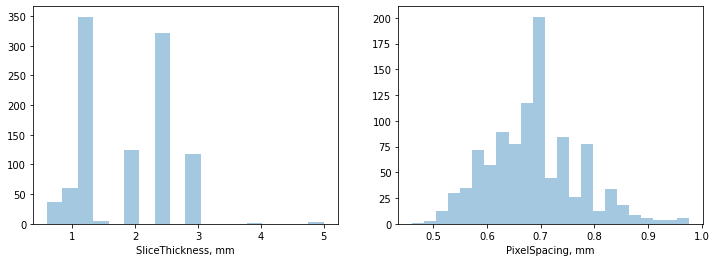

In [19]:
%matplotlib inline
import seaborn as sb
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ax=sb.distplot(CT_series["SliceThickness"].astype(float),kde=False)
ax.set(xlabel="SliceThickness, mm")

plt.subplot(1,2,2)
xSpacing = CT_series["pixelspa"].str.split('/',n=1,expand=True)[0].astype(float)
ax=sb.distplot(xSpacing, kde=False)
ax.set(xlabel="PixelSpacing, mm")

#### Build the list of files to download from IDC

In [287]:
import pandas as pd
s_1,s_2,s_3 = 5,5,5
ct_series_1 = CT_series[CT_series["SliceThickness"].astype(float)==1.0]
ct_series_2 = CT_series[CT_series["SliceThickness"].astype(float)==2.0]
ct_series_3 = CT_series[CT_series["SliceThickness"].astype(float)==3.0]
ct_series_HR = pd.concat([ct_series_1[:s_1],ct_series_2[:s_2],ct_series_3[:s_3]])

In [288]:
to_download = []
base_gs_uri = 'gs://idc-tcia-lidc-idri/dicom/'

for i in range(ct_series_HR.shape[0]):
    to_download.append(base_gs_uri + ct_series_HR.iloc[i]['StudyInstanceUID'] + '/' + ct_series_HR.iloc[i]['SeriesInstanceUID'])

manifest_df = pd.DataFrame({"gcs":to_download},columns=["gcs"])

In [289]:
manifest_df.head()

gcs
0  gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.1451...
1  gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.1451...
2  gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.1451...
3  gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.1451...
4  gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.1451...

In [290]:
manifest_df.to_csv("gcs_paths_3.txt",header=False, index=False)
!head gcs_paths_3.txt

gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.135045503670480596826162811572/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.165017330457520545748655969705/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.265704884949271879044145982159/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.815399168774050638734383723372/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.311849240521371267537044867782/1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120924524005910602207
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.461502489756528153281751961352/1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.

Need gsutil to download data from GCP storage

In [291]:
!pip install gsutil

     |████████████████████████████████| 2.9 MB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 15.5 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 65.3 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 8.0 MB/s  eta 0:00:01
     |████████████████████████████████| 54 kB 5.8 MB/s  eta 0:00:01
     |████████████████████████████████| 1.4 MB 44.0 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 13.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 60.2 MB/s eta 0:00:01
  Created wheel for gsutil: filename=gsutil-5.0-py3-none-any.whl size=3713420 sha256=7e4249fb701333ff31b7c085fd62dc95b23b166fc4eca3e88bd5684217151bce
  Stored in directory: /root/.cache/pip/wheels/3a/7c/68/4e828ee83d2d4806ff6d56d8deb6835ffec288abf82de57470
  Created wheel for crcmod: filename=crcmod-1.7-cp38-cp38-linux_x86_64.whl size=36029 sha256=563cac528ec9914f58d182126c74a807d2c570f54d2dde2c1a1995aca9d2de6a
  Stored in directory: /root/.cache/pi

In [292]:
!rm -rf downloaded_cohort_3

In [ ]:
!mkdir downloaded_cohort_3
!cat gcs_paths_3.txt | gsutil -u $myProjectID -m cp -Ir ./downloaded_cohort_3

Copying gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.135045503670480596826162811572/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288/1.3.6.1.4.1.14519.5.2.1.6279.6001.100191094280203283283021962486.dcm...
Copying gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.135045503670480596826162811572/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288/1.3.6.1.4.1.14519.5.2.1.6279.6001.101886964201437446907268755262.dcm...
Copying gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.135045503670480596826162811572/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288/1.3.6.1.4.1.14519.5.2.1.6279.6001.102247975018680800877284400958.dcm...
Copying gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.135045503670480596826162811572/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288/1.3.6.1.4.1.14519.5.2.1.6279.6001.105694608707088632797697113433.dcm...
Copying gs://idc-tcia-lidc-idri/dicom/1.

In [16]:
!python dicomsort/dicomsort.py -u downloaded_cohort_3 cohort_sorted_3/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm

  0%|                                                  | 0/3448 [00:00<?, ?it/s]
Source file: downloaded_cohort_3/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503/1.3.6.1.4.1.14519.5.2.1.6279.6001.284310817653432386643042030032.dcm
Target file: cohort_sorted_3/LIDC-IDRI-0084/1.3.6.1.4.1.14519.5.2.1.6279.6001.198480745206106280149820227940/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503/1.3.6.1.4.1.14519.5.2.1.6279.6001.284310817653432386643042030032.dcm

Target file already exists - pattern is probably not unique
Aborting to avoid data loss.
  0%|                                                  | 0/3448 [00:00<?, ?it/s]


#### Prepare data for training

In [10]:
import os
data_folder = os.getcwd() + '/cohort_sorted_3/'
data_folder

'/app/cohort_sorted_3/'

In [11]:
#f = open ('.pylidcrc','w')            #For GCP
f = open ('/root/.pylidcrc','w')    #For Colab
f.write('[dicom]'+'\n')
f.write('path =' + data_folder +'\n')
f.write('warn = True')
f.close()

Get all the patients folders in the DICOM sorted directory

Examine some images for the first patient

In [12]:
%matplotlib inline

patient_select = 0
print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])

    plt.subplot(nodule_num,3,3+i*3)
    plt.imshow(vol[cbbox][:,:,k],cmap='gray')
    # Plot the annotation contours for the kth slice.
    colors = ['r', 'g', 'b', 'y']
    for j in range(len(masks)):
        for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
            label = "Annotation %d" % (j+1)
            plt.plot(c[:,1], c[:,0], colors[j], label=label)

    # Plot the 50% consensus contour for the kth slice.
    for c in find_contours(cmask[:,:,k].astype(float), 0.5):
        plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

NameError: name 'patient_list' is not defined

We will need to extract the images from DICOM and save them as images into the disk for loading during training. pylidc is not multithreaded, we cannot load the images directly from the DICOM using generators in tf.data.Dataset. Let's split the patient list into train and test.

In [40]:
#def split patient list
def split_patients(patient_list, split=0.7):
    idxs = np.arange(len(patient_list))
    np.random.shuffle(idxs)
    num = len(patient_list)
    return np.array(patient_list)[idxs[:int(0.7*num)]], np.array(patient_list)[idxs[int(0.7*num):]]

In [41]:
train_patients, test_patients = split_patients(patient_list, 0.7)
print("Number of patients in train is {} and test is {}".format(len(train_patients), len(test_patients)))

Number of patients in train is 101 and test is 44


In [51]:
# CT_image_data = []
# CT_mask_data  = []
# #get volume for patient
# scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(['LIDC-IDRI-0347']))[0]
# nodules_annotation = scan.cluster_annotations()
# vol = scan.to_volume()
# CT_image_data.append(vol)

# #get mask for patient
# cmask_CT = []
# cbbox_CT = []
# masks_CT = []
# for nodule_idx, nodule in enumerate(nodules_annotation):
#     cmask, cbbox, masks = consensus(nodule)
#     cmask_CT.append(cmask)
#     cbbox_CT.append(cbbox)
#     masks_CT.append(masks)   

# CT_mask = np.zeros_like(vol)    
# nodule_num = len(cmask_CT)

# for i in range(nodule_num):
#     cmask = cmask_CT[i]
#     cbbox = cbbox_CT[i]
#     masks = masks_CT[i]    
#     CT_mask[cbbox] += cmask

# CT_mask_data.append(CT_mask)


# for j in range(CT_image_data[0].shape[2]):
#     image, mask = load_image(tf.expand_dims(CT_image_data[0][:,:,j], -1), tf.expand_dims(CT_mask_data[0][:,:,j], -1))
#     yield image, tf.keras.utils.to_categorical(mask, num_classes=2)

In [52]:
# print(len(CT_mask_data))
# print(len(CT_image_data))

In [53]:
import tensorflow as tf

In [54]:
## use a new data generator
## alternate, for more than one patient
## get the dataset generator
## WE WILL RUN INTO THREADING ISSUES WITH pl IF WE TRY TO PUT THE LOADING OF DICOM via pl IN A GENERATOR, LOOKS LIKE SAVING AS IMAGES IS THE ONLY OPTION
## sqlalchemy.exc.ProgrammingError: (sqlite3.ProgrammingError) SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140717684627264 and this is thread id 140711777265408.
## [SQL: SELECT scans.id AS scans_id, scans.study_instance_uid AS scans_study_instance_uid, scans.series_instance_uid AS scans_series_instance_uid, scans.patient_id AS scans_patient_id, scans.slice_thickness AS scans_slice_thickness, scans.pixel_spacing AS scans_pixel_spacing, scans.contrast_used AS scans_contrast_used, scans.is_from_initial AS scans_is_from_initial, scans.sorted_dicom_file_names AS scans_sorted_dicom_file_names 
## FROM scans 
## WHERE scans.patient_id IN ([POSTCOMPILE_patient_id_1])
##  LIMIT ? OFFSET ?]
## [parameters: [{}]]
## (Background on this error at: https://sqlalche.me/e/14/f405)

# def get_train_data_generator(train_patients):
#     for i in range(len(train_patients)):
        
#         #get volume for patient
#         scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([train_patients[i]]))[0]
#         nodules_annotation = scan.cluster_annotations()
#         vol = scan.to_volume()
        
#         #get mask for patient
#         cmask_CT = []
#         cbbox_CT = []
#         masks_CT = []
#         for nodule_idx, nodule in enumerate(nodules_annotation):
#             cmask, cbbox, masks = consensus(nodule)
#             cmask_CT.append(cmask)
#             cbbox_CT.append(cbbox)
#             masks_CT.append(masks)   

#         CT_mask = np.zeros_like(vol)    
#         nodule_num = len(cmask_CT)

#         for i in range(nodule_num):
#             cmask = cmask_CT[i]
#             cbbox = cbbox_CT[i]
#             masks = masks_CT[i]    
#             CT_mask[cbbox] += cmask
        
#         for j in range(vol.shape[2]):
#             image, mask = load_image(tf.expand_dims(vol[:,:,j], -1), tf.expand_dims(CT_mask[:,:,j], -1))
#             yield image, tf.keras.utils.to_categorical(mask, num_classes=2)

# def get_train_dataset_from_dicom(train_patients):
#     generator = lambda: get_train_data_generator(train_patients)
#     return tf.data.Dataset.from_generator(
#         generator, output_signature=(
#             tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32),
#             tf.TensorSpec(shape=(512, 512, 2), dtype=tf.float32)))

In [55]:
# ds_train = get_train_dataset_from_dicom(train_patients)
# ds_test = get_train_dataset_from_dicom(test_patients)

#### Extract and save images to a folder

We will use the PIL / Pillow to save the images extracted from DICOM to folders for train and test.
We will create the directories for the images, both train and test.

In [ ]:
# !mkdir -p data/train/images/
# !mkdir -p data/train/masks/
# !mkdir -p data/test/images/
# !mkdir -p data/test/masks/

In [9]:
# get image
from PIL import Image

# save image and mask
def save_patient_images_and_masks(patient_id, root_dir='/data/train'):
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    vol = scan.to_volume()

    # get mask for patient
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)   

    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)

    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]    
        CT_mask[cbbox] += cmask

    for slice_id in range(vol.shape[2]):
        image = vol[:,:,slice_id]
        mask = CT_mask[:,:,slice_id]
#         im = Image.fromarray(image)
#         msk = Image.fromarray(mask)
        image_file_name = root_dir + "/images/" + "img" + "_" + str(patient_id) + "_" + str(slice_id) + ".npz"
        mask_file_name = root_dir + "/masks/" + "mask" + "_" + str(patient_id) + "_" + str(slice_id) + ".npz"
#         im.convert('RGB').save(image_file_name)
#         msk.convert('RGB').save(mask_file_name)
        np.savez_compressed(image_file_name, image)
        np.savez_compressed(mask_file_name, mask)

In [66]:
!rm -rf data/train

In [8]:
ls /data

lost+found/


In [ ]:
image_path = '/data/images'
mask_path = '/data/masks'
root_dir  = '/data/train'
os.mkdir(root_dir)
os.mkdir(root_dir + '/images')
os.mkdir(root_dir + '/masks')
for pat in train_patients:
    save_patient_images_and_masks(pat, root_dir)

Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a 

In [ ]:
image_path = 'data/images'
mask_path = 'data/masks'
root_dir  = 'data/test'
for pat in test_patients:
    save_patient_images_and_masks(pat, root_dir)

In [47]:
ls data/train/images

img_LIDC-IDRI-0078_0.npy    img_LIDC-IDRI-0405_130.npy
img_LIDC-IDRI-0078_1.npy    img_LIDC-IDRI-0405_131.npy
img_LIDC-IDRI-0078_10.npy   img_LIDC-IDRI-0405_132.npy
img_LIDC-IDRI-0078_11.npy   img_LIDC-IDRI-0405_133.npy
img_LIDC-IDRI-0078_12.npy   img_LIDC-IDRI-0405_134.npy
img_LIDC-IDRI-0078_13.npy   img_LIDC-IDRI-0405_135.npy
img_LIDC-IDRI-0078_14.npy   img_LIDC-IDRI-0405_136.npy
img_LIDC-IDRI-0078_15.npy   img_LIDC-IDRI-0405_137.npy
img_LIDC-IDRI-0078_16.npy   img_LIDC-IDRI-0405_138.npy
img_LIDC-IDRI-0078_17.npy   img_LIDC-IDRI-0405_139.npy
img_LIDC-IDRI-0078_18.npy   img_LIDC-IDRI-0405_14.npy
img_LIDC-IDRI-0078_19.npy   img_LIDC-IDRI-0405_140.npy
img_LIDC-IDRI-0078_2.npy    img_LIDC-IDRI-0405_141.npy
img_LIDC-IDRI-0078_20.npy   img_LIDC-IDRI-0405_142.npy
img_LIDC-IDRI-0078_21.npy   img_LIDC-IDRI-0405_143.npy
img_LIDC-IDRI-0078_22.npy   img_LIDC-IDRI-0405_144.npy
img_LIDC-IDRI-0078_23.npy   img_LIDC-IDRI-0405_145.npy
img_LIDC-IDRI-0078_24.npy   img_LIDC-IDRI-0405_146.npy
img_LIDC-ID

Verify one of the images we saved

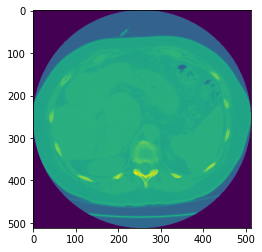

In [48]:
arr = np.load('data/train/images/img_LIDC-IDRI-0078_1.npy')
plt.imshow(arr)

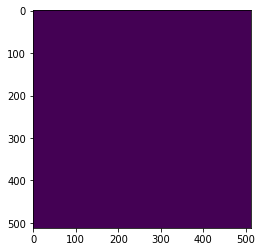

In [50]:
arr = np.load('data/train/masks/mask_LIDC-IDRI-0078_1.npy')
plt.imshow(arr)

In [58]:
arr.shape

(512, 512)

In [65]:
arr = Image.open('data/train/images/img_LIDC-IDRI-0347_2.jpg')
plt.imshow(arr)

In [66]:
# import os
# image_path = 'data/train/images'
# image_files = os.listdir(image_path)
# img = Image.open(image_path + "/" + image_files[0])
# img_array = np.array(img)
# img_array.shape

In [12]:
from PIL import Image

In [23]:
# get all patients
cohort = data_folder
patient_list = os.listdir(cohort)
print("There are {} patients".format(len(patient_list)))

There are 145 patients


### Load images from directory and view mask and contours

In [9]:
patient_id = 'LIDC-IDRI-0151' #'LIDC-IDRI-0433' #'LIDC-IDRI-0115' #'LIDC-IDRI-0115' #'LIDC-IDRI-0316'
data_dir = '/data/test'

test_images = os.listdir('/data/test/images')
train_images = os.listdir('/data/train/images')
tr_images = [img for img in train_images if img.find(patient_id) > 0]
tst_images = [img for img in test_images if img.find(patient_id) > 0]
print("train images list ={}, test images list = {}".format(len(tr_images), len(tst_images)))
images = []
if len(tst_images) > 0:
    images = tst_images
    data_dir = '/data/test'
else:
    images = tr_images
    data_dir = '/data/train'

image_dir = data_dir + '/images/'
mask_dir = data_dir + '/masks/'

masks = [img.replace('img', 'mask') for img in images]
print("Found {} images".format(len(images)))
#get annotations
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))
nodules_annotation = scan[0].cluster_annotations()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks) 

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
print("Number of nodules = {}".format(nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    #get the image file name
    img_filename = image_dir + "/" + "img_{}_{}.npz".format(patient_id, k_slice)
    img_arr = np.load(img_filename)
    #img_arr = np.array(img_arr)
    #plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.imshow(img_arr['arr_0'],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    
    plt.subplot(nodule_num,3,2+i*3)
    print("k_slice = {}".format(k_slice))
    #get the mask file name
    mask_filename = mask_dir + "/" + "mask_{}_{}.npz".format(patient_id, k_slice)
    mask_arr = np.load(mask_filename)
    #mask_arr = np.array(mask_arr)
#     CT_mask = np.zeros_like(vol)
#     CT_mask[cbbox] = cmask
#     plt.imshow(CT_mask[:,:,k_slice])
    plt.imshow(mask_arr['arr_0'])

    plt.subplot(nodule_num,3,3+i*3)
    x, y, z = cbbox
    plt.imshow(img_arr['arr_0'][(x,y)],cmap='gray')
    # Plot the annotation contours for the kth slice.
    colors = ['r', 'g', 'b', 'y']
    for j in range(len(masks)):
        for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
            label = "Annotation %d" % (j+1)
            plt.plot(c[:,1], c[:,0], colors[j], label=label)

    # Plot the 50% consensus contour for the kth slice.
    for c in find_contours(cmask[:,:,k].astype(float), 0.5):
        plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

train images list =111, test images list = 0
Found 111 images
Number of nodules = 1
k_slice = 74


In [57]:
img_arr['arr_0']
pred_mask = model.predict(tf.expand_dims(img_arr['arr_0'], -1))
pred_mask.shape

NameError: name 'model' is not defined

In [67]:
# st = 'img_LIDC-IDRI-0360_31.jpg'
# st.replace('img','mask')
# msk = Image.open(image_path + "/" + st).convert('L')
# msk = np.array(msk)
# msk

In [68]:
# st = 'img_LIDC-IDRI-0360_31.jpg'
# st.replace('img','mask')
# msk = Image.open(image_path + "/" + st)
# msk = np.array(msk)
# print(msk.shape)
# msk = tf.expand_dims(msk[:,:,0], -1)
# print(msk[:,:,0].shape)
# print(msk.shape)
# tf.keras.utils.to_categorical(msk, num_classes=2)

In [27]:
# print(msk.shape[0])
# n = msk.shape[0]
# categorical = np.zeros((512, 512, 2), dtype=np.int32)
# categorical[np.arange(n), msk]
# categorical.shape
# categorical

In [69]:
# image_files
# mask_files = []
#load_image(tf.expand_dims(img_array[:,:,0], -1))

Write some routines to normalize the images

In [58]:
def normalize(input_image):#, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    #input_mask -= 1
    return input_image#, input_mask

In [59]:
#optionally we can resize the images here
def load_image(image_data, mask_data):
    #use nearest, to prevent the labels from changing
    input_image = image_data#tf.image.resize(CT_image_data, (128, 128), method='nearest')
    #input_mask = tf.image.resize(CT_mask_data, (128, 128), method='nearest')
    input_mask = mask_data#tf.image.resize(CT_mask_data, (128, 128), method='nearest')

    input_image = normalize(input_image)

    return input_image, input_mask

### Load from numpy array

In [61]:
def train_data_generator(image_path, mask_path, image_files):
    for i in range(len(image_files)):
        img = np.load(image_path + "/" + image_files[i])['arr_0']
        
        mask_filename = image_files[i].replace('img','mask')
        msk = np.load(mask_path + "/" + mask_filename)['arr_0']
        
        image, mask = load_image(tf.expand_dims(img, -1), tf.expand_dims(msk, -1))
        mask = tf.cast(mask, tf.int32)
        yield image, tf.keras.utils.to_categorical(mask, num_classes=2)

def get_train_dataset_from_directory(image_path, mask_path, image_files):
    generator = lambda: train_data_generator(image_path, mask_path, image_files)
    return tf.data.Dataset.from_generator(
        generator, output_signature=(
            tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(512, 512, 2), dtype=tf.float32)))

In [74]:
# alternate, for more than one patient
# get the dataset generator
# image_path = 'data/train/images'
# mask_path = 'data/train/images'
# image_files = os.listdir(image_path)

def train_data_generator(image_path, mask_path, image_files):
    for i in range(len(image_files)):
        img = Image.open(image_path + "/" + image_files[i])
        img = np.array(img)
        mask_filename = image_files[i].replace('img','mask')
        msk = Image.open(mask_path + "/" + mask_filename).convert('1')
        msk = np.array(msk)
        image, mask = load_image(tf.expand_dims(img[:,:,0], -1), tf.expand_dims(msk, -1))
        mask = tf.cast(mask, tf.int32)
        yield image, tf.keras.utils.to_categorical(mask, num_classes=2)

def get_train_dataset_from_directory(image_path, mask_path, image_files):
    generator = lambda: train_data_generator(image_path, mask_path, image_files)
    return tf.data.Dataset.from_generator(
        generator, output_signature=(
            tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(512, 512, 2), dtype=tf.float32)))

In [62]:
import tensorflow as tf

2021-09-30 06:46:23.019147: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


In [63]:
image_path = '/data/train/images'
mask_path = '/data/train/masks'
image_files = os.listdir(image_path)
ds_train = get_train_dataset_from_directory(image_path, mask_path, image_files)

2021-09-30 06:46:33.837981: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2021-09-30 06:46:34.458354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 06:46:34.458972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-09-30 06:46:34.459019: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-09-30 06:46:34.797648: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-09-30 06:46:34.797752: I tensorflow/stream_executor/platform/default/

In [64]:
for i, m in ds_train.take(1):
    print(i.shape)
    print(m.shape)

2021-09-30 06:46:51.933216: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-30 06:46:51.971938: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz


(512, 512, 1)
(512, 512, 2)


In [66]:
image_path = '/data/test/images'
mask_path = '/data/test/masks'
image_files = os.listdir(image_path)
ds_test = get_train_dataset_from_directory(image_path, mask_path, image_files)

In [67]:
for i, m in ds_test.take(1):
    print(i.shape)
    print(m.shape)

(512, 512, 1)
(512, 512, 2)


In [68]:
dataset_train = ds_train.shuffle(320).batch(16)
#val data should not have batching, model.fit() will do batching?
dataset_test = ds_test.shuffle(320).batch(16)

In [69]:
for a, b in dataset_train.take(1):
    print(b.shape)

(16, 512, 512, 2)


In [81]:
# CT_image_data = []
# CT_mask_data  = []

# for pa in range(len(patient_list)):
#     print ("Current patient ID =", patient_list[pa])
    
#     scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
#     nodules_annotation = scan[pa].cluster_annotations()
#     vol = scan[pa].to_volume()
    
#     CT_image_data.append(vol)
    
#     cmask_CT = []
#     cbbox_CT = []
#     masks_CT = []
#     for nodule_idx, nodule in enumerate(nodules_annotation):
#         cmask, cbbox, masks = consensus(nodule)
#         cmask_CT.append(cmask)
#         cbbox_CT.append(cbbox)
#         masks_CT.append(masks)   

#     CT_mask = np.zeros_like(vol)    
#     nodule_num = len(cmask_CT)
#     print("Length of nodules = {}".format(nodule_num))
#     for i in range(nodule_num):
#         cmask = cmask_CT[i]
#         cbbox = cbbox_CT[i]
#         masks = masks_CT[i]    
#         CT_mask[cbbox] += cmask
#         print("Unique labels in mask = {}".format(np.unique(CT_mask[cbbox])))
        
#     CT_mask_data.append(CT_mask)

In [82]:
import tensorflow as tf

In [83]:
# def normalize(input_image):#, input_mask):
#     input_image = tf.cast(input_image, tf.float32) / 255.0
#     #input_mask -= 1
#     return input_image#, input_mask

In [84]:
# def load_image(CT_image_data, CT_mask_data):
#     #use nearest, to prevent the labels from changing
#     input_image = CT_image_data#tf.image.resize(CT_image_data, (128, 128), method='nearest')
#     #input_mask = tf.image.resize(CT_mask_data, (128, 128), method='nearest')
#     input_mask = CT_mask_data#tf.image.resize(CT_mask_data, (128, 128), method='nearest')

#     input_image = normalize(input_image)

#     return input_image, input_mask

In [85]:
# inp, msk = load_image(CT_image_data[0], CT_mask_data[0])
# print(inp.shape, msk.shape)

In [208]:
# def train_test_split(CT_image_data, CT_mask_data, split = 0.7):
#     assert len(CT_image_data) == len(CT_mask_data)
#     num_samples = len(CT_image_data)
#     idxs = np.arange(num_samples)
#     np.random.shuffle(idxs)
#     return CT_image_data[:int(num_samples*split)], CT_mask_data[:int(num_samples*split)],CT_image_data[int(num_samples*split):], CT_mask_data[int(num_samples*split):]

In [209]:
# CT_image_data_train, CT_mask_data_train, CT_image_data_test, CT_mask_data_test = train_test_split(CT_image_data, CT_mask_data)

In [86]:
# i = 0
# j = 0
# image, mask = load_image(tf.expand_dims(CT_image_data[i][:,:,j], -1), tf.expand_dims(CT_mask_data[i][:,:,j], -1))

In [87]:
# mask.shape

In [88]:
# print(mask.shape)
# mask_cat = tf.keras.utils.to_categorical(mask, num_classes=2)
# mask_cat.shape

In [89]:
# print(mask.shape[0])
# mask.shape

In [90]:
# np.max(mask)

In [92]:
# print(msk.shape)
# print(msk.dtype)
# #print(msk)
# msk1 = tf.cast(msk, tf.int16)
# n = msk1.shape[0]
# print(msk1.dtype)
# categorical = np.zeros((n, 2))
# print("shape=", categorical.shape)
# categorical[np.arange(n), mask]
# print(categorical.shape)
# print(categorical.dtype)
# categorical

In [93]:
# # alternate, for more than one patient
# # get the dataset generator
# def get_train_data_generator_bodytext(CT_image_data, CT_mask_data):
#     for i in range(len(CT_image_data)):
#         for j in range(CT_image_data[i].shape[2]):
#             image, mask = load_image(tf.expand_dims(CT_image_data[i][:,:,j], -1), tf.expand_dims(CT_mask_data[i][:,:,j], -1))
#             yield image, tf.keras.utils.to_categorical(mask, num_classes=2)
#         # yield image, mask
# def get_train_dataset(CT_image_data, CT_mask_data):
#     generator = lambda: get_train_data_generator_bodytext(CT_image_data, CT_mask_data)
#     return tf.data.Dataset.from_generator(
#         generator, output_signature=(
#             tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32),
#             tf.TensorSpec(shape=(512, 512, 2), dtype=tf.float32)))

In [94]:
# # alternate, for more than one patient
# # get the dataset generator
# def get_train_data_generator_bodytext(CT_image_data, CT_mask_data):
#     for i in range(len(CT_image_data)):
#         for j in range(CT_image_data[i].shape[2]):
#             image, mask = load_image(tf.expand_dims(CT_image_data[i][:,:,j], -1), tf.expand_dims(CT_mask_data[i][:,:,j], -1))
#             yield image, mask
#         # yield image, mask
# def get_train_dataset(CT_image_data, CT_mask_data):
#     generator = lambda: get_train_data_generator_bodytext(CT_image_data, CT_mask_data)
#     return tf.data.Dataset.from_generator(
#         generator, output_signature=(
#             tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32),
#             tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32)))

In [95]:
tf.__version__

'2.5.0'

In [189]:
# ds_train = get_train_dataset(CT_image_data_train,CT_mask_data_train)
# ds_train.element_spec

In [190]:
# ds_test = get_train_dataset(CT_image_data_test,CT_mask_data_test)
# ds_test.element_spec

In [96]:
# for d, l in ds_train.take(1):
#     print(l.shape)

In [97]:
# for d, l in ds_test.take(1):
#     print(l.shape)

In [78]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        #print(display_list[i])
        plt.imshow(display_list[i])
        #plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

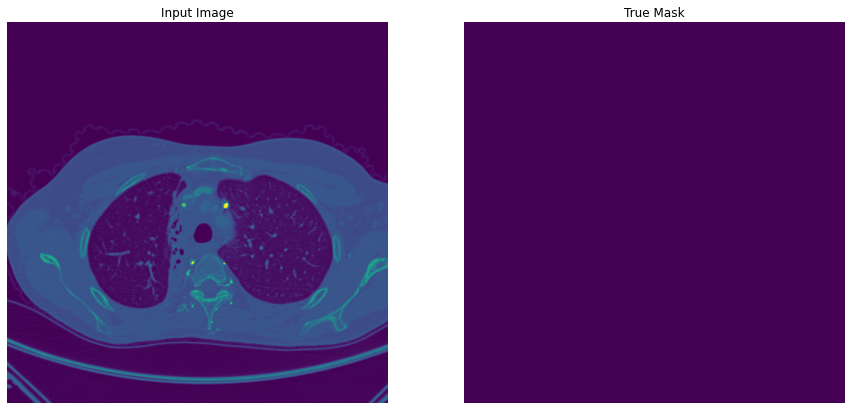

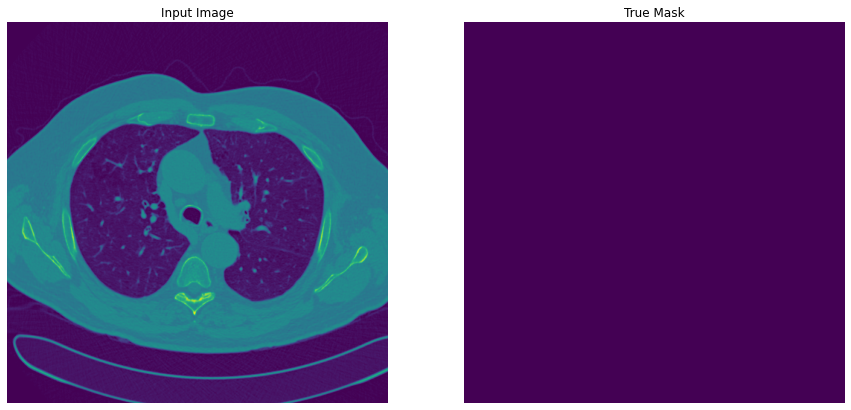

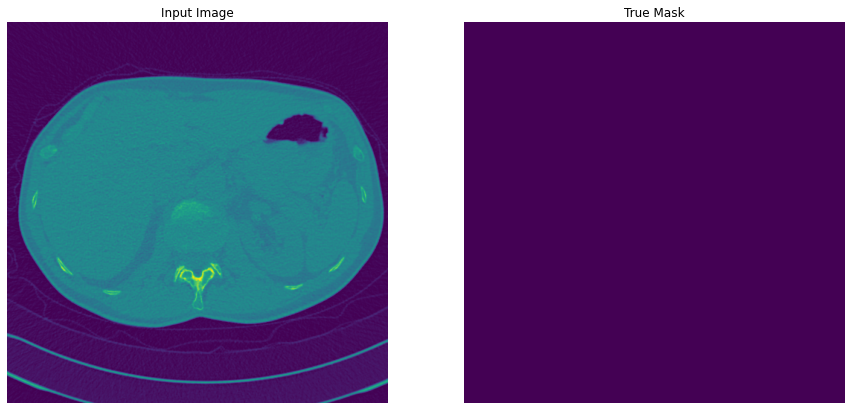

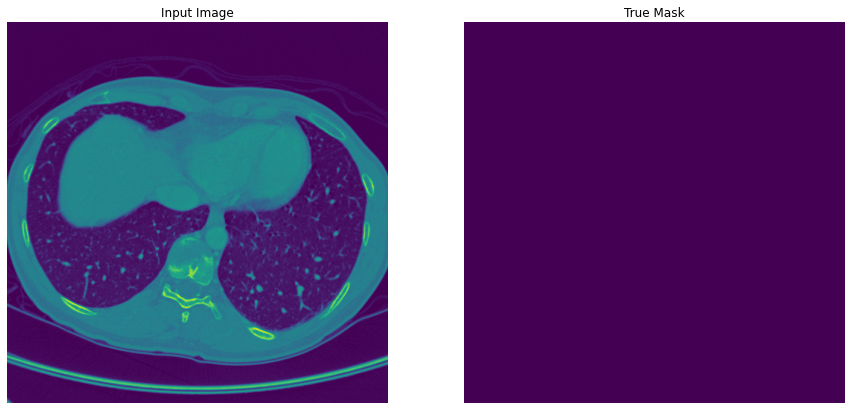

In [79]:
for images, masks in ds_train.shuffle(300).take(5):
    sample_image, sample_mask = images[:,:,0], masks[:,:,0]
    display([sample_image, sample_mask])

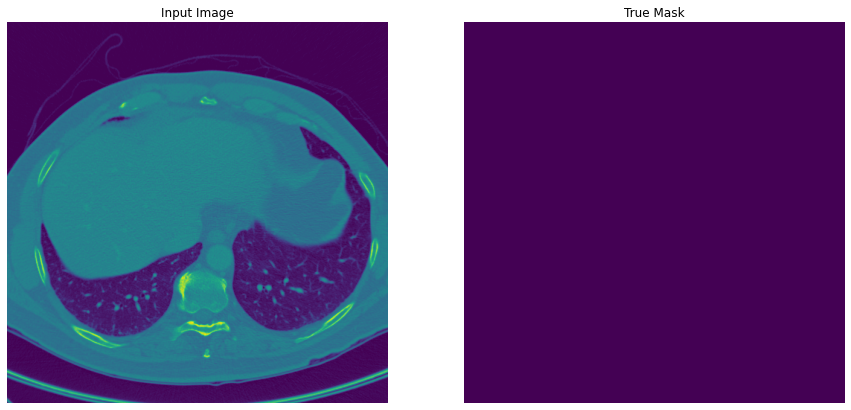

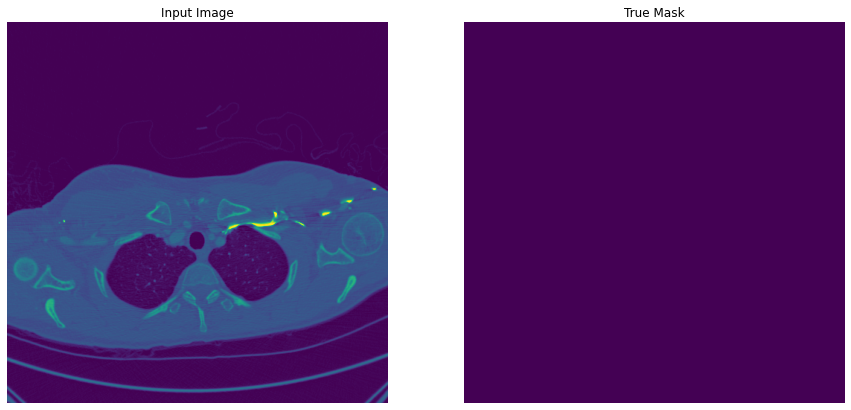

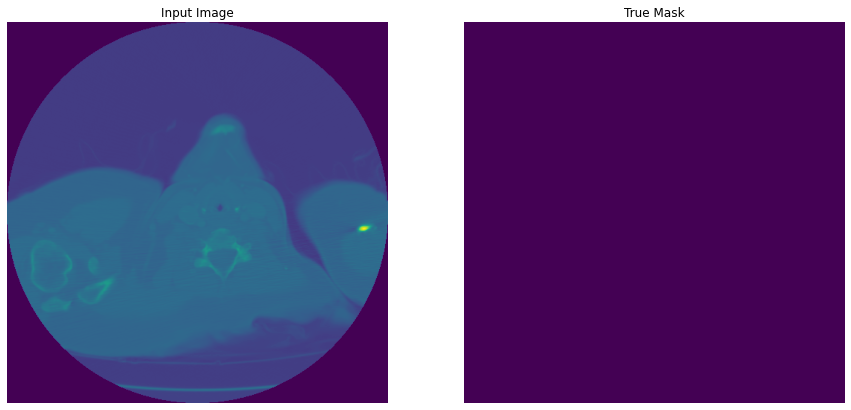

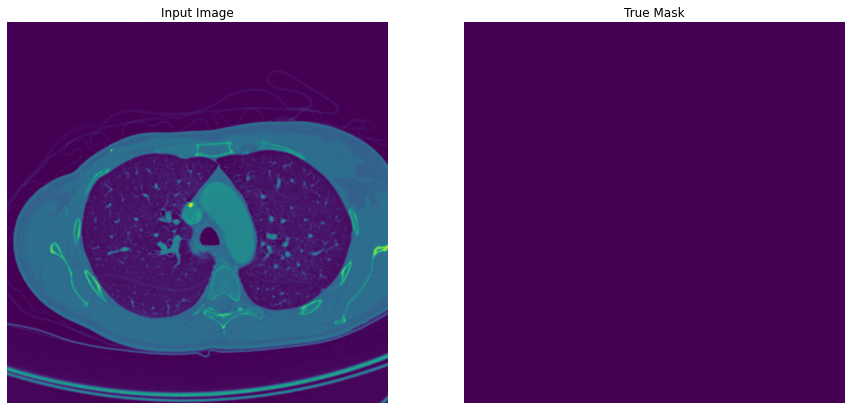

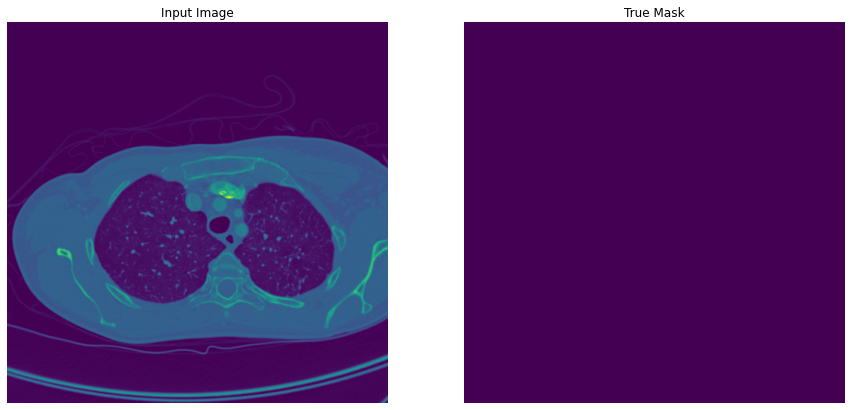

In [80]:
for images, masks in ds_test.shuffle(300).take(5):
    sample_image, sample_mask = images[:,:,0], masks[:,:,0]
    display([sample_image, sample_mask])

In [20]:
#!pip install git+https://github.com/jakeret/unet.git

In [21]:
#!pip list | grep tensorflow

In [22]:
#!pip list | grep unet

In [23]:
#!pip install tensorflow-gpu

In [81]:
import tensorflow as tf
tf.test.gpu_device_name()

2021-09-30 06:49:04.252521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 06:49:04.252871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-09-30 06:49:04.253026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 06:49:04.253333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 06:49:04.253561: I tensorflow/core/common_runtime/gp

'/device:GPU:0'

In [19]:
# import unet
# from unet.datasets import circles

In [26]:
# LEARNING_RATE = 1e-3
# unet_model = unet.build_model(channels=1,
#                               num_classes=2,
#                               layer_depth=2,
#                               filters_root=64)
# unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [27]:
# trainer = unet.Trainer(checkpoint_callback=False,
#                        learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
#                        warmup_proportion=0.1,
#                        learning_rate=LEARNING_RATE)
# trainer.fit(unet_model,
#             ds_train,
#             ds_train,
#             epochs=25,
#             batch_size=1)

In [82]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from PIL import Image

In [81]:
# def get_model(IMG_HEIGHT, IMG_WIDTH):
#     in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3 ))

#     conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
#     conv1 = Dropout(0.2)(conv1)
#     conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
#     pool1 = MaxPooling2D((2, 2))(conv1)

#     conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
#     conv2 = Dropout(0.2)(conv2)
#     conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
#     pool2 = MaxPooling2D((2, 2))(conv2)

#     conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
#     conv3 = Dropout(0.2)(conv3)
#     conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
#     pool3 = MaxPooling2D((2, 2))(conv3)

#     conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
#     conv4 = Dropout(0.2)(conv4)
#     conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

#     up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
#     conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
#     conv5 = Dropout(0.2)(conv5)
#     conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
#     up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
#     conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
#     conv6 = Dropout(0.2)(conv6)
#     conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

#     up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
#     conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
#     conv7 = Dropout(0.2)(conv7)
#     conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
#     segmentation = Conv2D(3, (1, 1), activation='sigmoid', name='seg')(conv7)

#     model = Model(inputs=[in1], outputs=[segmentation])

#     losses = {'seg': 'binary_crossentropy'
#             }

#     metrics = {'seg': ['acc']
#                 }
#     model.compile(optimizer="adam", loss = losses, metrics=metrics)

#     return model

In [82]:
# model = get_model(512, 512)
# model.summary()

In [31]:
# !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xf images.tar.gz
# !tar -xf annotations.tar.gz

In [44]:
# import os

# input_dir = "images/"
# target_dir = "annotations/trimaps/"
# img_size = (160, 160)
# num_classes = 3
# batch_size = 32

# input_img_paths = sorted(
#     [
#         os.path.join(input_dir, fname)
#         for fname in os.listdir(input_dir)
#         if fname.endswith(".jpg")
#     ]
# )
# target_img_paths = sorted(
#     [
#         os.path.join(target_dir, fname)
#         for fname in os.listdir(target_dir)
#         if fname.endswith(".png") and not fname.startswith(".")
#     ]
# )

# print("Number of samples:", len(input_img_paths))

# for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
#     print(input_path, "|", target_path)

In [33]:
# from IPython.display import Image, display
# from tensorflow.keras.preprocessing.image import load_img
# import PIL
# from PIL import ImageOps

# # Display input image #7
# display(Image(filename=input_img_paths[9]))

# # Display auto-contrast version of corresponding target (per-pixel categories)
# img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
# display(img)

In [34]:
# from tensorflow import keras
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img


# class OxfordPets(keras.utils.Sequence):
#     """Helper to iterate over the data (as Numpy arrays)."""

#     def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
#         self.batch_size = batch_size
#         self.img_size = img_size
#         self.input_img_paths = input_img_paths
#         self.target_img_paths = target_img_paths

#     def __len__(self):
#         return len(self.target_img_paths) // self.batch_size

#     def __getitem__(self, idx):
#         """Returns tuple (input, target) correspond to batch #idx."""
#         i = idx * self.batch_size
#         batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
#         batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
#         x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
#         for j, path in enumerate(batch_input_img_paths):
#             img = load_img(path, target_size=self.img_size)
#             x[j] = img
#         y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
#         for j, path in enumerate(batch_target_img_paths):
#             img = load_img(path, target_size=self.img_size, color_mode="grayscale")
#             y[j] = np.expand_dims(img, 2)
#             # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
#             y[j] -= 1
#         return x, y

In [35]:
# import random

# # Split our img paths into a training and a validation set
# val_samples = 1000
# random.Random(1337).shuffle(input_img_paths)
# random.Random(1337).shuffle(target_img_paths)
# train_input_img_paths = input_img_paths[:-val_samples]
# train_target_img_paths = target_img_paths[:-val_samples]
# val_input_img_paths = input_img_paths[-val_samples:]
# val_target_img_paths = target_img_paths[-val_samples:]

# # Instantiate data Sequences for each split
# train_gen = OxfordPets(
#     batch_size, img_size, train_input_img_paths, train_target_img_paths
# )
# val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [401]:
#a, b = train_gen[0]
img_size = (512, 512)
inputs = keras.Input(shape=img_size + (1,))
inputs

<KerasTensor: shape=(None, 512, 512, 1) dtype=float32 (created by layer 'input_4')>

In [83]:
img_size = (512, 512)
num_classes = 2
batch_size = 12

In [84]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

NameError: name 'keras' is not defined

In [85]:
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
#keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [408]:
# ds_train = get_train_dataset(CT_image_data_train,CT_mask_data_train)
# ds_test = get_train_dataset(CT_image_data_test,CT_mask_data_test)
# ds_train = ds_train.shuffle(320).batch(16)
# #val data should not have batching, model.fit() will do batching?
# ds_test = ds_test.shuffle(320).batch(16)

In [86]:
model.output_shape

(None, 512, 512, 2)

In [87]:
model.input_shape

(None, 512, 512, 1)

In [27]:
img_arr[:,:,0].shape

(512, 512)

In [91]:
img_arr['arr_0'].shape

(512, 512)

In [94]:
inp = np.expand_dims(img_arr['arr_0'], -1)
inp.shape

(512, 512, 1)

In [95]:
model.predict(inp).shape

(512, 512, 16, 2)

In [25]:
img_arr[:,:,0]
pred_mask = model.predict(tf.expand_dims(img_arr[:,:,0], -1))
pred_mask.shape
#model.predict()

2021-09-29 14:22:49.071445: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-29 14:22:49.072010: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz
2021-09-29 14:22:49.562703: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2021-09-29 14:22:50.278979: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2021-09-29 14:22:51.106040: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-09-29 14:22:51.778846: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


(512, 512, 16, 2)

Create the training checkpoints

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [106]:
from keras import backend as K
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    return tf.reduce_mean( (2. * intersection + smooth) / (union + smooth), axis=0)

# def mean_iou(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.dtypes.float64)
#     y_pred = tf.cast(y_pred, tf.dtypes.float64)
#     I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
#     U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
#     return tf.reduce_mean(I / U)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=[dice_coef, iou_coef])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 25
history = model.fit(dataset_train, epochs=epochs, validation_data=dataset_test, callbacks=callbacks)

Epoch 1/25


2021-09-29 06:40:47.051105: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2021-09-29 06:40:54.611099: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2021-09-29 06:41:03.457496: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-09-29 06:41:11.955741: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


1416/1416 [==============================] - 2840s 2s/step - loss: 0.0022 - dice_coef: 0.9995 - iou_coef: 0.9993 - val_loss: 0.0000e+00 - val_dice_coef: 1.0000 - val_iou_coef: 1.0000


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/25
1416/1416 [==============================] - 2015s 1s/step - loss: 0.0000e+00 - dice_coef: 1.0000 - iou_coef: 1.0000 - val_loss: 0.0000e+00 - val_dice_coef: 1.0000 - val_iou_coef: 1.0000
Epoch 3/25
 139/1416 [=>............................] - ETA: 26:01 - loss: 0.0000e+00 - dice_coef: 1.0000 - iou_coef: 1.0000

KeyboardInterrupt: 

In [139]:
model.output_shape

(None, 512, 512, 2)

In [141]:
model.input_shape

(None, 512, 512, 1)

In [124]:
ds_test.element_spec

(TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(512, 512, 2), dtype=tf.float32, name=None))

In [121]:
for image, mask in ds_test.take(1):
    pred_mask = model.predict(image)

In [127]:
image.shape

TensorShape([512, 512, 1])

In [132]:
for images, masks in dataset_test.take(1):
    break

In [135]:
images[0].shape

TensorShape([512, 512, 1])

In [144]:
tf.expand_dims(images[0], 0)

<tf.Tensor: shape=(1, 512, 512, 1), dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]], dtype=float32)>

In [145]:
pr = model.predict(tf.expand_dims(images[0], 0))

In [148]:
pr.shape
tf.argmax(pr, axis=-1)

<tf.Tensor: shape=(1, 512, 512), dtype=int64, numpy=
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])>

In [147]:
pred_mask.shape

(512, 512, 16, 2)

In [123]:
tf.argmax(pred_mask, axis=-1)

<tf.Tensor: shape=(512, 512, 16), dtype=int64, numpy=
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

In [120]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [163]:
tf.math.argmax(mask, axis=-1)

<tf.Tensor: shape=(512, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>

In [157]:
mask[0]
tf.math.argmax(mask[0], axis=1)

<tf.Tensor: shape=(512,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

In [181]:
for image_batch, mask_batch in dataset_train.take(5):
    for mask in mask_batch:
        mask = tf.math.argmax(mask, axis=-1)
        print(np.max(mask))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [190]:
train_images

['img_LIDC-IDRI-0360_31.jpg',
 'img_LIDC-IDRI-0319_142.jpg',
 'img_LIDC-IDRI-0319_169.jpg',
 'img_LIDC-IDRI-0532_273.jpg',
 'img_LIDC-IDRI-0729_274.jpg',
 'img_LIDC-IDRI-0825_87.jpg',
 'img_LIDC-IDRI-0119_244.jpg',
 'img_LIDC-IDRI-0736_64.jpg',
 'img_LIDC-IDRI-0433_100.jpg',
 'img_LIDC-IDRI-0770_232.jpg',
 'img_LIDC-IDRI-0404_52.jpg',
 'img_LIDC-IDRI-0412_268.jpg',
 'img_LIDC-IDRI-0320_71.jpg',
 'img_LIDC-IDRI-0084_9.jpg',
 'img_LIDC-IDRI-0766_247.jpg',
 'img_LIDC-IDRI-0761_142.jpg',
 'img_LIDC-IDRI-0742_90.jpg',
 'img_LIDC-IDRI-0602_276.jpg',
 'img_LIDC-IDRI-0808_203.jpg',
 'img_LIDC-IDRI-0735_177.jpg',
 'img_LIDC-IDRI-0127_89.jpg',
 'img_LIDC-IDRI-0409_287.jpg',
 'img_LIDC-IDRI-0362_103.jpg',
 'img_LIDC-IDRI-0106_5.jpg',
 'img_LIDC-IDRI-0428_168.jpg',
 'img_LIDC-IDRI-0761_89.jpg',
 'img_LIDC-IDRI-0521_130.jpg',
 'img_LIDC-IDRI-0451_97.jpg',
 'img_LIDC-IDRI-0119_252.jpg',
 'img_LIDC-IDRI-0119_231.jpg',
 'img_LIDC-IDRI-0142_13.jpg',
 'img_LIDC-IDRI-0763_155.jpg',
 'img_LIDC-IDRI-0419_1

In [193]:
#LIDC-IDRI-0316
#LIDC-IDRI-0360
train_images = os.listdir('data/train/images')
train_masks = os.listdir('data/train/masks')

images = [tr for tr in train_images  if tr.find('LIDC-IDRI-0360')>0]
masks = [tr for tr in train_masks  if tr.find('LIDC-IDRI-0360')>0]

In [196]:
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(['LIDC-IDRI-0360']))[0]
nodules_annotation = scan.cluster_annotations()
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    print(cbbox)

(slice(242, 250, None), slice(193, 200, None), slice(104, 117, None))
(slice(192, 199, None), slice(161, 170, None), slice(154, 159, None))
(slice(255, 273, None), slice(332, 346, None), slice(147, 167, None))
(slice(275, 291, None), slice(207, 222, None), slice(217, 227, None))


In [259]:
patient_list

['LIDC-IDRI-0316',
 'LIDC-IDRI-0115',
 'LIDC-IDRI-0433',
 'LIDC-IDRI-0151',
 'LIDC-IDRI-0742',
 'LIDC-IDRI-0136',
 'LIDC-IDRI-0354',
 'LIDC-IDRI-0425',
 'LIDC-IDRI-0294',
 'LIDC-IDRI-0142',
 'LIDC-IDRI-0098',
 'LIDC-IDRI-0763',
 'LIDC-IDRI-0601',
 'LIDC-IDRI-0381',
 'LIDC-IDRI-0086',
 'LIDC-IDRI-0107',
 'LIDC-IDRI-0084',
 'LIDC-IDRI-0315',
 'LIDC-IDRI-0735',
 'LIDC-IDRI-0325',
 'LIDC-IDRI-0505',
 'LIDC-IDRI-0347',
 'LIDC-IDRI-0296',
 'LIDC-IDRI-0859',
 'LIDC-IDRI-0468',
 'LIDC-IDRI-0521',
 'LIDC-IDRI-0412',
 'LIDC-IDRI-0309',
 'LIDC-IDRI-0567',
 'LIDC-IDRI-0388',
 'LIDC-IDRI-0141',
 'LIDC-IDRI-0154',
 'LIDC-IDRI-0508',
 'LIDC-IDRI-0510',
 'LIDC-IDRI-0303',
 'LIDC-IDRI-0454',
 'LIDC-IDRI-0414',
 'LIDC-IDRI-0382',
 'LIDC-IDRI-0400',
 'LIDC-IDRI-0398',
 'LIDC-IDRI-0366',
 'LIDC-IDRI-0320',
 'LIDC-IDRI-0419',
 'LIDC-IDRI-0132',
 'LIDC-IDRI-0893',
 'LIDC-IDRI-0404',
 'LIDC-IDRI-0444',
 'LIDC-IDRI-0106',
 'LIDC-IDRI-0729',
 'LIDC-IDRI-0360',
 'LIDC-IDRI-0648',
 'LIDC-IDRI-0358',
 'LIDC-IDRI-

In [232]:
print(cmask.shape)
k_slice

(16, 15, 10)


222

In [273]:
cmask.shape

(31, 30, 8)

In [279]:
patient_id = 'LIDC-IDRI-0115'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
nodules_annotation = scan.cluster_annotations()
vol = scan.to_volume()
# get mask for patient
cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

CT_mask = np.zeros_like(vol)    
nodule_num = len(cmask_CT)

for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]    
    CT_mask[cbbox] += cmask

    
    
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
x, y, z = cbbox
k_slice = int((z.start + z.stop)/2)
image = vol[:,:,slice_id]
mask = mask[:,:,k_slice]
im = Image.fromarray(image).convert('L')
msk = Image.fromarray(mask).convert('L')
a[ctr].imshow(im)
print(np.unique(mask))

Loading dicom files ... This may take a moment.


92

In [ ]:
def get_mask_slices(patient_id):
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    vol = scan.to_volume()
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)

Loading dicom files ... This may take a moment.
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


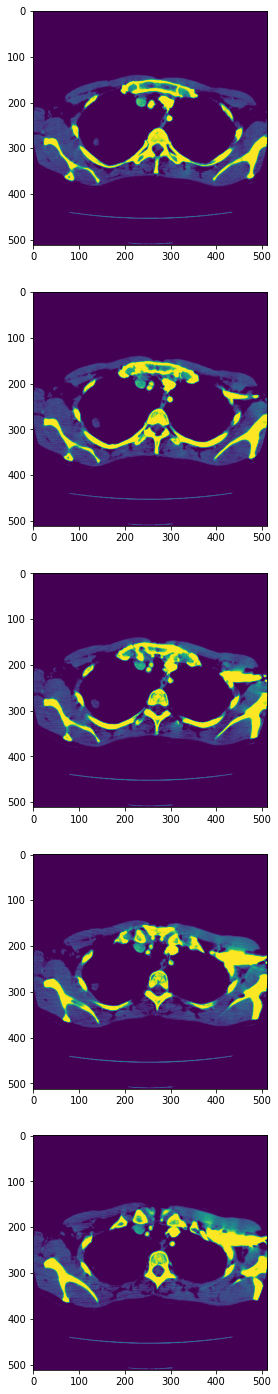

In [269]:
#code to save images from DICOM
patient_id = 'LIDC-IDRI-0115'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
nodules_annotation = scan.cluster_annotations()
vol = scan.to_volume()

# get mask for patient
cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

CT_mask = np.zeros_like(vol)    
nodule_num = len(cmask_CT)

for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]    
    CT_mask[cbbox] += cmask

f, a = plt.subplots(5, figsize=(25,25))
ctr = 0
for slice_id in range(vol.shape[2]):
    if slice_id > 89 and slice_id<95:
        image = vol[:,:,slice_id]
        mask = CT_mask[:,:,slice_id]
        im = Image.fromarray(image).convert('L')
        msk = Image.fromarray(mask).convert('L')
        a[ctr].imshow(im)
        print(np.unique(mask))
        ctr += 1
    #plt.imshow(im)
#     image_file_name = root_dir + "/images/" + "img" + "_" + str(patient_id) + "_" + str(slice_id) + ".jpg"
#     mask_file_name = root_dir + "/masks/" + "mask" + "_" + str(patient_id) + "_" + str(slice_id) + ".jpg"
#     im.convert('RGB').save(image_file_name)
#     msk.convert('RGB').save(mask_file_name)

In [261]:
x, y, z = cbbox
z

slice(88, 96, None)

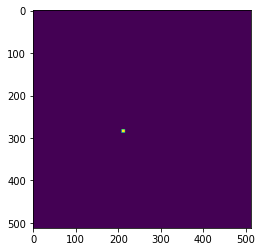

In [271]:
data_path = 'data/train/images'
mask_path = 'data/train/masks'
#cbbox[0]
str_name = "img_LIDC-IDRI-0360_{}.jpg".format(220)
msk_name = "mask_LIDC-IDRI-0360_{}.jpg".format(220)
image_file = data_path + "/" + str_name
mask_file = mask_path + "/" + msk_name

arr = Image.open(mask_file).convert('L')
plt.imshow(arr)

#show the mask

In [207]:
images[0]

'img_LIDC-IDRI-0360_31.jpg'

16


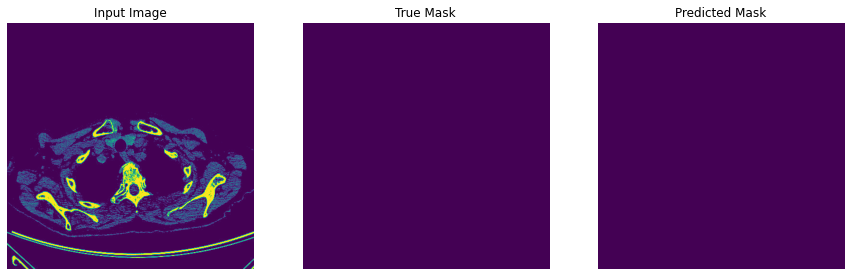

In [177]:
for image_batch, mask_batch in dataset_train.take(1):
    print(len(image_batch))
    image = image_batch[0]
    mask = mask_batch[0]
    image = tf.expand_dims(image, 0)
    pred_mask = model.predict(image)
    display([image[0], tf.math.argmax(mask, axis=-1), create_mask(pred_mask)])
    break
    #pred_mask = model.predict(image)

In [178]:
mask

<tf.Tensor: shape=(512, 512, 2), dtype=float32, numpy=
array([[[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       ...,

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]], dtype=float32)>

In [118]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

TypeError: Invalid shape (512, 512, 2) for image data

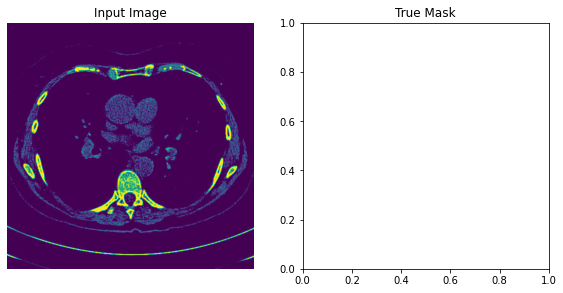

In [119]:
show_predictions(dataset_test)

In [221]:
model.evaluate(ds_test)

98/98 [==============================] - 40s 376ms/step - loss: 5.5371e-04 - dice_coef: 1.0000 - mean_iou: 0.5000


[0.0005537146935239434, 0.9999590516090393, 0.4999791383743286]

In [231]:
history.history['val_loss']

[0.0010635093785822392,
 0.0008838046342134476,
 0.0006877629202790558,
 0.0013641304103657603,
 0.0015939020086079836,
 0.0009870071662589908,
 0.0015042992308735847,
 0.0008939673425629735,
 0.0010082272347062826,
 0.001202841172926128,
 0.0007157313521020114,
 0.0009874537354335189,
 0.0005706144729629159,
 0.0006370800547301769,
 0.0020984886214137077,
 0.0005856667994521558,
 0.0007005248335190117,
 0.0006221610237844288,
 0.0010281644063070416,
 0.0009039140422828496,
 0.0010204784339293838,
 0.0011563629377633333,
 0.0009395101806148887,
 0.0007165780407376587,
 0.0009634668822400272]

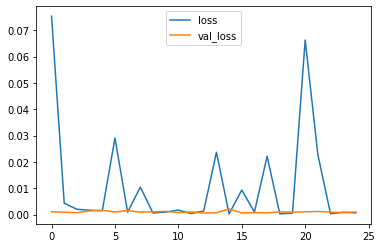

In [247]:
val_loss_metric = history.history['val_loss']
loss_metric = history.history['loss']
x = np.arange(len(val_loss_metric))
plt.plot(x, loss_metric, label='loss')
plt.plot(x, val_loss_metric, label='val_loss')
plt.legend()

In [248]:
history.history

{'loss': [0.07535067200660706,
  0.004304432775825262,
  0.002010576194152236,
  0.0016499232733622193,
  0.001427853712812066,
  0.02902889810502529,
  0.0009095562854781747,
  0.01041964441537857,
  0.0005834561306983232,
  0.0009467678610235453,
  0.0016810728702694178,
  0.00037979960325174034,
  0.001336453715339303,
  0.02365736849606037,
  0.00023508611775469035,
  0.00931416917592287,
  0.0009451068472117186,
  0.02217717096209526,
  0.00026979134418070316,
  0.0005394820473156869,
  0.06632902473211288,
  0.022722432389855385,
  0.0002968781627714634,
  0.0008619187865406275,
  0.0006478848517872393],
 'dice_coef': [0.9925232529640198,
  0.998672366142273,
  0.9995559453964233,
  0.9995682239532471,
  0.9993705749511719,
  0.9928926229476929,
  0.9995850324630737,
  0.9970077872276306,
  0.9998155236244202,
  0.9997632503509521,
  0.9991077780723572,
  0.9998812079429626,
  0.9994709491729736,
  0.9924828410148621,
  0.9999160170555115,
  0.9959320425987244,
  0.99948215484619

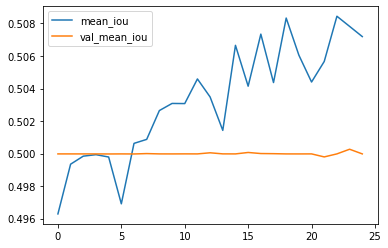

In [249]:
mean_iou = history.history['mean_iou']
val_mean_iou = history.history['val_mean_iou']
x = np.arange(len(val_mean_iou))
plt.plot(x, mean_iou, label='mean_iou')
plt.plot(x, val_mean_iou, label='val_mean_iou')
plt.legend()

In [250]:
dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']
x = np.arange(len(val_dice_coef))
plt.plot(x, dice_coef, label='dice_coef')
plt.plot(x, val_dice_coef, label='val_dice_coef')
plt.legend()

In [68]:
for a, b in ds_train.take(1):
    print(b[0])

tf.Tensor(
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], shape=(512, 512, 1), dtype=float32)


In [71]:
np.min(b[0])

0.0